In [7]:
import tensorflow as tf
import math
from tqdm import tqdm
import numpy as np
import os
import time
import cv2
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import scipy as scipy
from collections import Counter
from Erosion import crop_rice_grains
import uuid
import gc


from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input,Dense, Conv2D,GlobalAveragePooling2D,Dropout,Flatten,BatchNormalization,Concatenate,InputLayer,AveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import AdamW


%matplotlib inline

# Initialize Defect Model

In [8]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

config = base_model.get_config()
new_model = tf.keras.models.Model.from_config(config) # <- new_model architecture

x_model = new_model.output
# x_model = data_augmentation(x_model)  
x_model = GlobalAveragePooling2D()(x_model)
x_model = BatchNormalization()(x_model)
x_model = Dropout(0.3)(x_model)
x_model = Dense(128,activation='relu')(x_model)
x_model = BatchNormalization()(x_model)
x_model = Dense(128,activation='relu')(x_model)
x_model = Dropout(0.3)(x_model)
x_model = Dense(64,activation='relu')(x_model)
x_model = Dropout(0.3)(x_model)

predictions = Dense(5, activation='softmax')(x_model)
model = Model(inputs=new_model.input, outputs=predictions)

model.load_weights('/media/new_volumn/MP_DEFECT/models/defect/modelsB0V4.keras')


# Load dataset

In [9]:
path_1509 = "/media/nas/MP/segmentation/hovernet/PNG_Paddy07-2024/PUSA_PADDY-1509_HARYANA_3-7-24/"
path_1121 = "/media/nas/MP/segmentation/hovernet/PNG_Paddy07-2024/PUSA_PADDY_1121_HARYANA_8-7-2024/"

In [10]:
path_1509_npz = [f'{path_1509}{npz}'for npz in os.listdir(path_1509)]
path_1121_npz = [f'{path_1121}{npz}'for npz in os.listdir(path_1121)]
print(path_1509_npz[0])
print(path_1121_npz[0])

all_breed_npz = path_1509_npz + path_1121_npz # our interested breed

/media/nas/MP/segmentation/hovernet/PNG_Paddy07-2024/PUSA_PADDY-1509_HARYANA_3-7-24/PUSA_PADDY 1509_HARYANA_ 03.07.2024_20240703_0022.npz
/media/nas/MP/segmentation/hovernet/PNG_Paddy07-2024/PUSA_PADDY_1121_HARYANA_8-7-2024/PUSA_PADDY 1121_HARYANA_ 08.07.2024_20240709_0003.npz


In [11]:
def transform(images):
    X_test_resized = tf.image.resize(images['kernel_pics'], (224, 224))

    # # Normalize images to the range [0, 1]
    X_test_normalized = X_test_resized / 255.0

    return np.array(X_test_normalized)

In [12]:
# A set to keep track of generated UUIDs for uniqueness check
generated_uuids = set()

def evaluate(X_test, npz_prefix, breed_type, npz_filename):

    list_normal_rice = []

    data_dict = [
                    'broke',
                    'dual',
                    'half',
                    'normal',
                    'over'
                ]
    # Perform batch prediction
    Y_pred = model.predict(X_test, verbose=0) 
    y_pred = np.argmax(Y_pred, axis=1)  # Get class indices for the whole batch

    # Set base evaluation directory
    base_dir = "/media/new_volumn/SimDINO/IndianDefects"
    os.makedirs(base_dir, exist_ok=True)

    # Training data directory
    training_dir = "/media/new_volumn/SimDINO/images_india"
    os.makedirs(training_dir, exist_ok=True)
    training_breed_type = os.path.join(training_dir, breed_type)
    os.makedirs(training_breed_type, exist_ok=True)

    # NPZ directory
    npz_dir = "/media/new_volumn/SimDINO/npz_india"
    os.makedirs(npz_dir, exist_ok=True)

    for i, (image, pred_class) in enumerate(zip(X_test, y_pred)):
        class_label = data_dict[pred_class]  # Get class name from index
        # breed_dir = os.path.join(base_dir, breed_type)
        # Create breed directory if it doesn't exist
        # os.makedirs(breed_dir, exist_ok=True)
        # Create class directory if it doesn't exist
        # class_dir = os.path.join(breed_dir, class_label)
        # os.makedirs(class_dir, exist_ok=True)

        # unique_id = uuid.uuid4().hex
        # while unique_id in generated_uuids:
        #     unique_id = uuid.uuid4().hex
        # generated_uuids.add(unique_id)

        # Define save path for defect
        # save_path_defect = os.path.join(class_dir, f"{npz_prefix}_{unique_id}.png")

        # Convert image to NumPy and save
        # image_np = image.numpy() 
        image_pil = Image.fromarray((image * 255).astype(np.uint8)) 
        # image_pil.save(save_path_defect)
        

        if class_label == "normal":
            # save_path_training = os.path.join(training_breed_type, f"{npz_prefix}_{unique_id}.png")
            # image_pil.save(save_path_training)
            list_normal_rice.append(image_pil)

    list_normal_rice = np.array(list_normal_rice)
    np.savez_compressed(f"{npz_dir}/{npz_filename}", kernel_pics=list_normal_rice)




In [ ]:
for count, npz in enumerate(tqdm(all_breed_npz, desc="looping through npz")):
    sample_images = np.load(npz)['kernel_pics'].astype('uint8')
    npz_prefix = npz.split('/')[-1].split('.')[0] # obtain the prefix before .npz
    breed_type = npz.split('/')[-1].split(" ")[-2].split("_")[0] # obtain the breed type (e.g, 1509, 1121)
    X_test, npz_prefix = crop_rice_grains(sample_images, npz_prefix) # apply erosion and dilation, and normalization
    npz_filename = npz.split("/")[-1] # obtain original npz filename
    evaluate(X_test, npz_prefix, breed_type, npz_filename)
    
del model
gc.collect()

looping through npz:   0%|          | 0/53 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1742269811.246566  451198 service.cc:148] XLA service 0x7fbff814bbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742269811.246625  451198 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-18 10:50:11.331649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742269811.670817  451198 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-18 10:50:11.795853: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which 

Skipping image 338: No rice grain found.
Skipping image 600: No rice grain found.


looping through npz:   6%|▌         | 3/53 [00:27<07:08,  8.57s/it]

Skipping image 5: No rice grain found.
Skipping image 22: No rice grain found.


looping through npz:   8%|▊         | 4/53 [00:35<06:32,  8.00s/it]

Skipping image 210: No rice grain found.
Skipping image 384: No rice grain found.


looping through npz:  11%|█▏        | 6/53 [00:48<05:36,  7.15s/it]

Skipping image 597: No rice grain found.


looping through npz:  15%|█▌        | 8/53 [00:58<04:26,  5.92s/it]

Skipping image 43: No rice grain found.
Skipping image 86: No rice grain found.
Skipping image 103: No rice grain found.
Skipping image 192: No rice grain found.


looping through npz:  17%|█▋        | 9/53 [01:05<04:34,  6.25s/it]

Skipping image 8: No rice grain found.
Skipping image 630: No rice grain found.


looping through npz:  19%|█▉        | 10/53 [01:09<03:54,  5.46s/it]

Skipping image 34: No rice grain found.
Skipping image 176: No rice grain found.


looping through npz:  21%|██        | 11/53 [01:16<04:09,  5.94s/it]

Skipping image 12: No rice grain found.
Skipping image 262: No rice grain found.
Skipping image 311: No rice grain found.
Skipping image 542: No rice grain found.


looping through npz:  25%|██▍       | 13/53 [01:30<04:17,  6.45s/it]

Skipping image 39: No rice grain found.
Skipping image 276: No rice grain found.
Skipping image 584: No rice grain found.


looping through npz:  28%|██▊       | 15/53 [01:43<04:11,  6.61s/it]

Skipping image 0: No rice grain found.
Skipping image 4: No rice grain found.
Skipping image 8: No rice grain found.
Skipping image 240: No rice grain found.
Skipping image 511: No rice grain found.


looping through npz:  30%|███       | 16/53 [01:47<03:31,  5.71s/it]

Skipping image 2: No rice grain found.
Skipping image 586: No rice grain found.


looping through npz:  32%|███▏      | 17/53 [01:50<03:02,  5.08s/it]

Skipping image 246: No rice grain found.


looping through npz:  34%|███▍      | 18/53 [01:54<02:42,  4.63s/it]

Skipping image 13: No rice grain found.


looping through npz:  36%|███▌      | 19/53 [01:57<02:25,  4.27s/it]

Skipping image 306: No rice grain found.


looping through npz:  40%|███▉      | 21/53 [02:11<03:00,  5.63s/it]

Skipping image 43: No rice grain found.
Skipping image 75: No rice grain found.
Skipping image 132: No rice grain found.
Skipping image 166: No rice grain found.


looping through npz:  42%|████▏     | 22/53 [02:18<03:06,  6.02s/it]

Skipping image 16: No rice grain found.
Skipping image 441: No rice grain found.


looping through npz:  45%|████▌     | 24/53 [02:25<02:17,  4.72s/it]

Skipping image 327: No rice grain found.
Skipping image 449: No rice grain found.


looping through npz:  47%|████▋     | 25/53 [02:32<02:29,  5.33s/it]

Skipping image 308: No rice grain found.
Skipping image 412: No rice grain found.


looping through npz:  49%|████▉     | 26/53 [02:39<02:37,  5.82s/it]

Skipping image 0: No rice grain found.


looping through npz:  53%|█████▎    | 28/53 [02:46<01:57,  4.70s/it]

Skipping image 100: No rice grain found.
Skipping image 337: No rice grain found.


looping through npz:  55%|█████▍    | 29/53 [02:53<02:09,  5.39s/it]

Skipping image 0: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 3: No rice grain found.
Skipping image 11: No rice grain found.


looping through npz:  57%|█████▋    | 30/53 [02:57<01:52,  4.90s/it]

Skipping image 5: No rice grain found.
Skipping image 7: No rice grain found.
Skipping image 23: No rice grain found.


looping through npz:  60%|██████    | 32/53 [03:07<01:44,  4.97s/it]

Skipping image 201: No rice grain found.


looping through npz:  66%|██████▌   | 35/53 [03:22<01:28,  4.90s/it]

Skipping image 265: No rice grain found.


looping through npz:  68%|██████▊   | 36/53 [03:26<01:17,  4.53s/it]

Skipping image 16: No rice grain found.
Skipping image 35: No rice grain found.
Skipping image 221: No rice grain found.
Skipping image 575: No rice grain found.


looping through npz:  70%|██████▉   | 37/53 [03:29<01:08,  4.26s/it]

Skipping image 8: No rice grain found.
Skipping image 231: No rice grain found.
Skipping image 260: No rice grain found.


looping through npz:  72%|███████▏  | 38/53 [03:33<01:01,  4.12s/it]

Skipping image 0: No rice grain found.
Skipping image 2: No rice grain found.
Skipping image 4: No rice grain found.
Skipping image 46: No rice grain found.


looping through npz:  79%|███████▉  | 42/53 [03:52<00:54,  4.94s/it]

Skipping image 9: No rice grain found.
Skipping image 10: No rice grain found.
Skipping image 49: No rice grain found.
Skipping image 226: No rice grain found.


looping through npz:  83%|████████▎ | 44/53 [03:59<00:39,  4.37s/it]

Skipping image 6: No rice grain found.


looping through npz:  85%|████████▍ | 45/53 [04:03<00:33,  4.24s/it]

Skipping image 6: No rice grain found.


looping through npz:  87%|████████▋ | 46/53 [04:10<00:36,  5.16s/it]

Skipping image 34: No rice grain found.
Skipping image 177: No rice grain found.
Skipping image 585: No rice grain found.


looping through npz:  89%|████████▊ | 47/53 [04:14<00:28,  4.69s/it]

Skipping image 9: No rice grain found.
Skipping image 58: No rice grain found.


looping through npz:  94%|█████████▍| 50/53 [04:28<00:15,  5.03s/it]

Skipping image 41: No rice grain found.


looping through npz:  96%|█████████▌| 51/53 [04:32<00:09,  4.56s/it]

Skipping image 44: No rice grain found.
Skipping image 251: No rice grain found.
Skipping image 376: No rice grain found.
Skipping image 616: No rice grain found.


looping through npz:  98%|█████████▊| 52/53 [04:39<00:05,  5.31s/it]

Skipping image 4: No rice grain found.
Skipping image 63: No rice grain found.


looping through npz: 100%|██████████| 53/53 [04:43<00:00,  5.35s/it]


41947

: 

In [42]:
test_file = "npz_india/PUSA_PADDY 1509_HARYANA_ 03.07.2024_20240703_0022.npz"
test_npz = np.load(test_file)

In [ ]:
test_npz['kernel_pics'].shape

(333, 224, 224, 3)

: 

# Statistics

/tmp/ipykernel_419565/4163173266.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_419565/4163173266.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


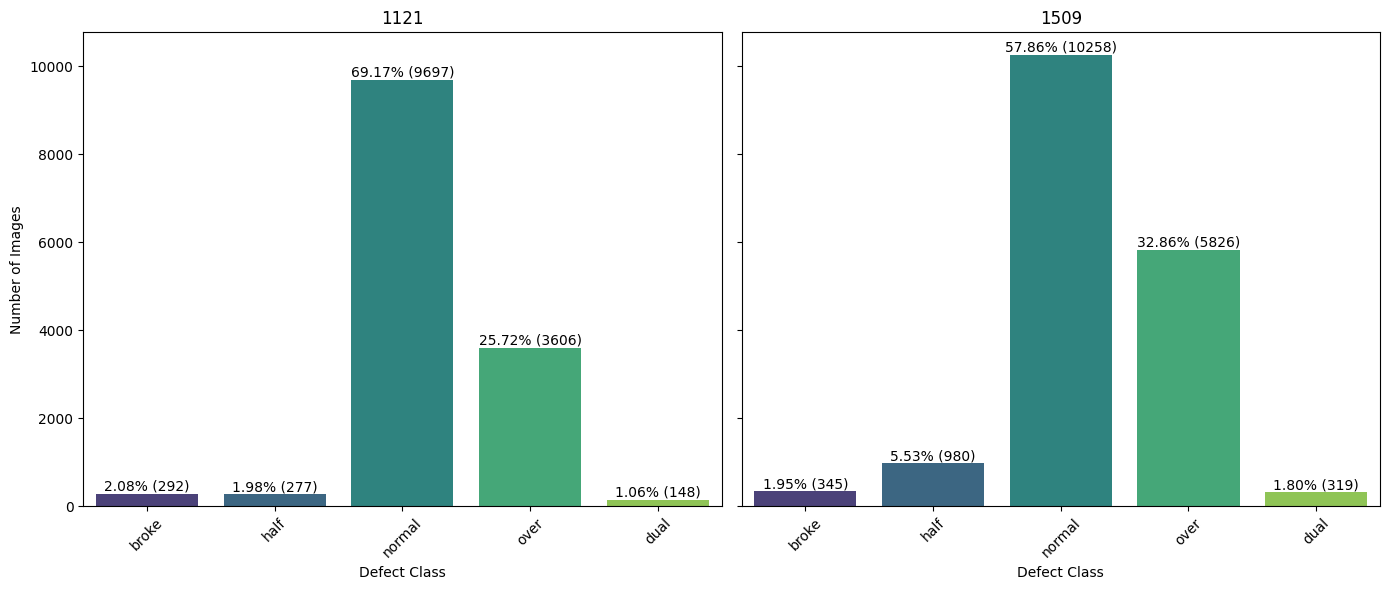

: 

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dataset path
dataset_path = "IndianDefects/"  # Change this if your path is different

# Dictionary to store class counts separately for each variety
class_counts = {"1121": {}, "1509": {}}

# Loop through each variety (1121, 1509)
for variety in os.listdir(dataset_path):  # e.g., 1121, 1509
    variety_path = os.path.join(dataset_path, variety)

    if os.path.isdir(variety_path) and variety in class_counts:
        for defect_class in os.listdir(variety_path):  # e.g., broke, dual, half, etc.
            class_path = os.path.join(variety_path, defect_class)

            if os.path.isdir(class_path):  # Ensure it's a directory
                num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
                
                # Store the count in the correct variety category
                class_counts[variety][defect_class] = num_images

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # Two subplots side by side

for i, variety in enumerate(["1121", "1509"]):
    if class_counts[variety]:  # Only plot if there are images
        total_images = sum(class_counts[variety].values())  # Total images in the variety
        
        # Plot the barplot
        sns.barplot(
            x=list(class_counts[variety].keys()), 
            y=list(class_counts[variety].values()), 
            ax=axes[i], palette="viridis"
        )
        
        # Add percentage labels on top of each bar
        for idx, count in enumerate(class_counts[variety].values()):
            percentage = (count / total_images) * 100
            axes[i].text(idx, count + 0.5, f"{percentage:.2f}% ({count})", ha='center', va='bottom', fontsize=10)

        axes[i].set_title(f"{variety}")
        axes[i].set_xlabel("Defect Class")
        axes[i].set_ylabel("Number of Images")
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

plt.tight_layout()
plt.show()
